In [39]:
import pandas as pd
import numpy as np
import pickle

import re
import string


from textblob import TextBlob #pip install textblob
from spellchecker import SpellChecker

import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

from wordcloud import WordCloud

from collections import Counter

# Read Dataset

In [40]:
app=pd.read_csv('app_details.csv')
review=pd.read_csv('Playstore_Google_Apps_User_Reviews.csv')

In [41]:
review_new= review.loc[:,['content','score','at','appId']]
print(review_new.shape)
review_new.head(2)

(95003, 4)


,content,score,at,appId
0,Working with this app is so difficult. Default...,1,2021-01-26 14:53:28,com.google.android.contacts
1,I would give it 0 stars if possible. No option...,1,2021-01-31 07:36:32,com.google.android.contacts


In [42]:
app_new=app.loc[:,['title','summary','genre','installs','minInstalls','score','ratings','reviews','free','released','appId']]
print(app_new.shape)
app_new.head(2)

(82, 11)


,title,summary,genre,installs,minInstalls,score,ratings,reviews,free,released,appId
0,Contacts,Back up your contacts & access them anywhere,Communication,"500,000,000+",500000000,4.284028,532472,134994,True,"Dec 7, 2015",com.google.android.contacts
1,Phone by Google - Caller ID & Spam Protection,"Reliable phone calls with spam protection, cal...",Tools,"500,000,000+",500000000,3.893445,322539,112878,True,"Dec 7, 2015",com.google.android.dialer


In [5]:
#Merge two data set
df=pd.merge(review_new, app_new, on="appId", how='left')
df.shape

(95003, 14)

# Prepare & Clean data for modeling

### Text Preprocessing Steps
- remove number, captal letters, and punctuation

In [43]:
alphanum=lambda x: re.sub('\w*\d\w*','',str(x))
punc_lower=lambda x: re.sub(('[^-9A-Za-z ]'),'',x.lower())
df['content']=df.content.map(alphanum).map(punc_lower)

- reduce the letter repeat more 2

In [44]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

df['content']=df.content.map(reduce_lengthening)

- removing extra white spaces

In [45]:
remove_extraspace=lambda x: re.sub("\s+"," ", x)
df['content']=df.content.map(remove_extraspace)

- Lemmatization (nltk.download('wordnet'))
 - standardize words to their root form by using morphological analysis (lemmatization)
 - Singular word only

In [46]:
lemmatizer = WordNetLemmatizer()
def original_word(x):
    word_list = nltk.word_tokenize(x)
    word_list =[lemmatizer.lemmatize(w, 'v') for w in word_list]
    #word_list =[lemmatizer.lemmatize(w, 'a') for w in word_list]
    word_list =[lemmatizer.lemmatize(w) for w in word_list]
    lemmatized_output = ' '.join([w for w in word_list])
    return lemmatized_output
df['content']=df.content.map(original_word)

- other text cleaning

In [47]:
df['content']=list(map(lambda x : x.replace('ads','ad'),df['content']))
df['content']=list(map(lambda x : x.replace('advertisementsi','ad'),df['content']))
df['content']=list(map(lambda x : x.replace('videos','video'),df['content']))
df['content']=list(map(lambda x : x.replace(' r ',' '),df['content']))
df['content']=list(map(lambda x : x.replace(' s ',' '),df['content']))
df['content']=list(map(lambda x : x.replace(' i ',' '),df['content']))

# Save file for later use (All text)

In [11]:
df.to_pickle("all_data.pkl")

# Text Document with Noun & Adjective & Verb Only

In [12]:
def nouns_adj_V(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ' or pos[:2] == 'VB'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [13]:
data_nouns_adj_V = df.copy()
data_nouns_adj_V['content']=data_nouns_adj_V.content.apply(nouns_adj_V)

In [14]:
data_nouns_adj_V.to_pickle("data_nouns_adj_V.pkl")

# Text Document with Noun & Adjective Only

In [15]:
def nouns_V(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'VB'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [16]:
data_nouns_V = df.copy()
data_nouns_V['content']=df.content.apply(nouns_V)

In [17]:
data_nouns_V.to_pickle("data_nouns_V.pkl")

# Text Document with Noun Only

In [48]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [49]:
data_nouns = df.copy()
data_nouns['content']= df.content.apply(nouns)

In [50]:
data_nouns.to_pickle("data_nouns.pkl")

# EDA
- Most Common Words

In [21]:
cv=CountVectorizer(stop_words='english')
df_cv = cv.fit_transform(df['content'])
df_review=pd.DataFrame(df_cv.toarray(), 
                       index= [df.title], 
                       columns=cv.get_feature_names())

In [22]:
df_review.head(2)

,aa,aab,aababc,aac,aaccedently,aaccha,aacha,aacount,aad,aaegi,...,zx,zxfg,zxx,zy,zyada,zync,zz,zzaaza,zzte,zzu
title,,,,,,,,,,,,,,,,,,,,,
Contacts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Contacts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_review2=df_review.groupby(df_review.index).sum()
df_review2

,aa,aab,aababc,aac,aaccedently,aaccha,aacha,aacount,aad,aaegi,...,zx,zxfg,zxx,zy,zyada,zync,zz,zzaaza,zzte,zzu
"(Android Accessibility Suite,)",3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Android Auto - Google Maps, Media & Messaging,)",93,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Android Device Policy,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Android System WebView,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Android TV Core Services,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(YouTube,)",2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
"(YouTube Kids,)",0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
"(YouTube Music - Stream Songs & Music Videos,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(YouTube Studio,)",2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- find the top 30 words said by each app

In [24]:
df_review2=df_review2.transpose()

top_dict={}
for wd in df_review2.columns:
    top=df_review2[wd].sort_values(ascending=False).head(30)
    top_dict[wd]=list(zip(top.index, top.values))

#len(top_dict)#82
top_dict  

{('Android Accessibility Suite',): [('app', 379),
  ('use', 293),
  ('phone', 267),
  ('good', 193),
  ('work', 183),
  ('read', 166),
  ('android', 155),
  ('accessibility', 146),
  ('need', 140),
  ('update', 140),
  ('like', 137),
  ('screen', 135),
  ('talkback', 133),
  ('time', 115),
  ('dont', 114),
  ('just', 105),
  ('make', 104),
  ('google', 103),
  ('turn', 98),
  ('feature', 94),
  ('apps', 94),
  ('im', 93),
  ('problem', 84),
  ('great', 84),
  ('option', 81),
  ('text', 80),
  ('want', 78),
  ('thing', 75),
  ('button', 75),
  ('device', 74)],
 ('Android Auto - Google Maps, Media & Messaging',): [('work', 732),
  ('phone', 630),
  ('app', 515),
  ('use', 461),
  ('car', 430),
  ('android', 418),
  ('auto', 349),
  ('connect', 338),
  ('update', 294),
  ('time', 257),
  ('google', 235),
  ('great', 226),
  ('issue', 217),
  ('screen', 205),
  ('map', 200),
  ('doesnt', 177),
  ('music', 176),
  ('just', 172),
  ('like', 156),
  ('good', 139),
  ('usb', 139),
  ('play', 1

- Look at the most top words--> add them to the stop word list
  - first pull out the top 30 words for each app.

In [25]:
words=[]
for app in df_review2.columns:
    top=[word for (word, count) in top_dict[app]]
    for t in top:
        words.append(t)
words

['app',
 'use',
 'phone',
 'good',
 'work',
 'read',
 'android',
 'accessibility',
 'need',
 'update',
 'like',
 'screen',
 'talkback',
 'time',
 'dont',
 'just',
 'make',
 'google',
 'turn',
 'feature',
 'apps',
 'im',
 'problem',
 'great',
 'option',
 'text',
 'want',
 'thing',
 'button',
 'device',
 'work',
 'phone',
 'app',
 'use',
 'car',
 'android',
 'auto',
 'connect',
 'update',
 'time',
 'google',
 'great',
 'issue',
 'screen',
 'map',
 'doesnt',
 'music',
 'just',
 'like',
 'good',
 'usb',
 'play',
 'fix',
 'cable',
 'need',
 'new',
 'apps',
 'plug',
 'im',
 'try',
 'app',
 'work',
 'good',
 'update',
 'use',
 'device',
 'phone',
 'google',
 'profile',
 'account',
 'apps',
 'android',
 'nice',
 'time',
 'install',
 'make',
 'help',
 'ok',
 'just',
 'policy',
 'need',
 'school',
 'download',
 'doesnt',
 'access',
 'dont',
 'personal',
 'great',
 'problem',
 'instal',
 'update',
 'app',
 'chrome',
 'google',
 'good',
 'phone',
 'try',
 'problem',
 'android',
 'work',
 'fix',
 '

In [26]:
Counter(words).most_common()

[('app', 82),
 ('use', 82),
 ('good', 80),
 ('just', 79),
 ('google', 79),
 ('like', 77),
 ('work', 75),
 ('time', 73),
 ('need', 71),
 ('dont', 69),
 ('phone', 67),
 ('make', 67),
 ('update', 66),
 ('great', 57),
 ('option', 42),
 ('fix', 42),
 ('doesnt', 39),
 ('im', 38),
 ('try', 37),
 ('want', 32),
 ('add', 31),
 ('feature', 29),
 ('problem', 29),
 ('nice', 25),
 ('really', 25),
 ('apps', 21),
 ('new', 21),
 ('say', 20),
 ('love', 19),
 ('issue', 18),
 ('play', 18),
 ('download', 18),
 ('screen', 16),
 ('device', 15),
 ('account', 14),
 ('open', 14),
 ('change', 14),
 ('turn', 12),
 ('video', 12),
 ('android', 11),
 ('thing', 11),
 ('photo', 11),
 ('text', 10),
 ('know', 10),
 ('way', 10),
 ('better', 9),
 ('help', 8),
 ('data', 8),
 ('search', 8),
 ('edit', 8),
 ('picture', 8),
 ('image', 8),
 ('star', 8),
 ('map', 7),
 ('pay', 7),
 ('keyboard', 7),
 ('set', 7),
 ('view', 7),
 ('service', 7),
 ('day', 7),
 ('save', 7),
 ('word', 7),
 ('read', 6),
 ('connect', 6),
 ('thank', 6),
 (

In [27]:
add_stop_words=[word for word, count in Counter(words).most_common() if count > 42]
add_stop_words

['app',
 'use',
 'good',
 'just',
 'google',
 'like',
 'work',
 'time',
 'need',
 'dont',
 'phone',
 'make',
 'update',
 'great']

- update our document-term matrix with the new list of stop words

In [28]:
stop_words1=text.ENGLISH_STOP_WORDS.union(add_stop_words)

## Word Cloud

In [29]:
wc=WordCloud(stopwords=stop_words1, 
             background_color='white', colormap='Dark2',
             max_font_size=150, random_state=42)

In [30]:
top5_app=df.groupby("title")["score_y"].mean().sort_values(ascending=False).head(5)
last5_app=df.groupby("title")["score_y"].mean().sort_values(ascending=False).tail(5)

In [31]:
df.content

0        work with this app be so difficult default num...
1        i would give it star if possible no option for...
2        dear google find a very critical bugcustom rin...
3        worst interface evercant even add a new contac...
4        while open a save contact entry this app doesn...
                               ...                        
94998              google be so super app this app be nice
94999    it a great app if you like history all you nee...
95000                           all at the tip of a finger
95001                         great to teach child history
95002                                             good app
Name: content, Length: 95003, dtype: object

#### Word Cloud for all document

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



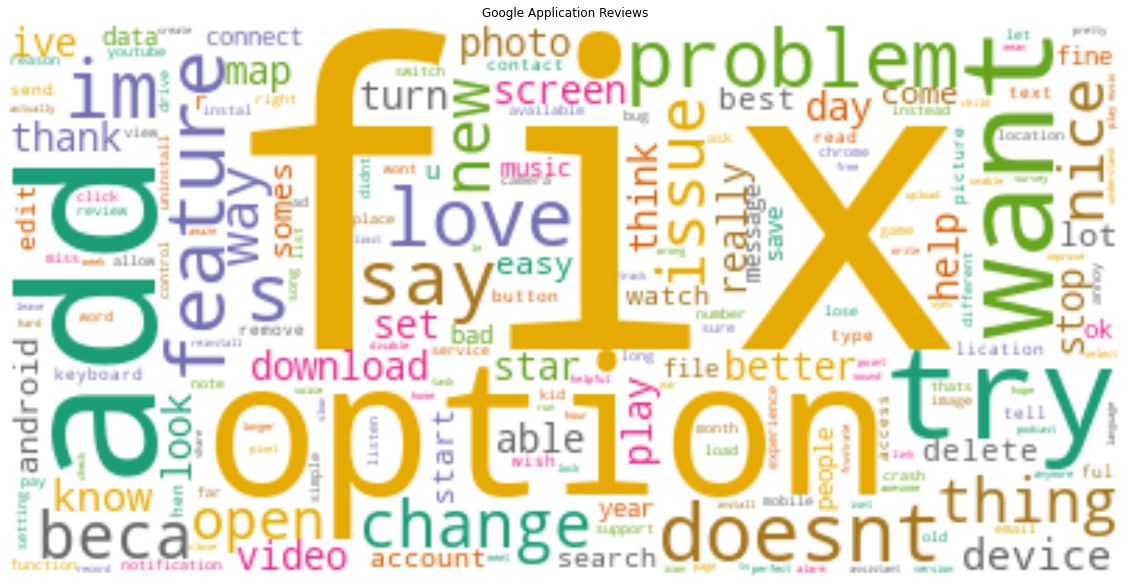

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =[20,20]

strings=' '.join(df.content)
for stop_word in add_stop_words:
        strings=strings.replace(stop_word,'')
wc.generate(strings)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Google Application Reviews')
print(strings)

### Word Cloud for Top 5 rate apps

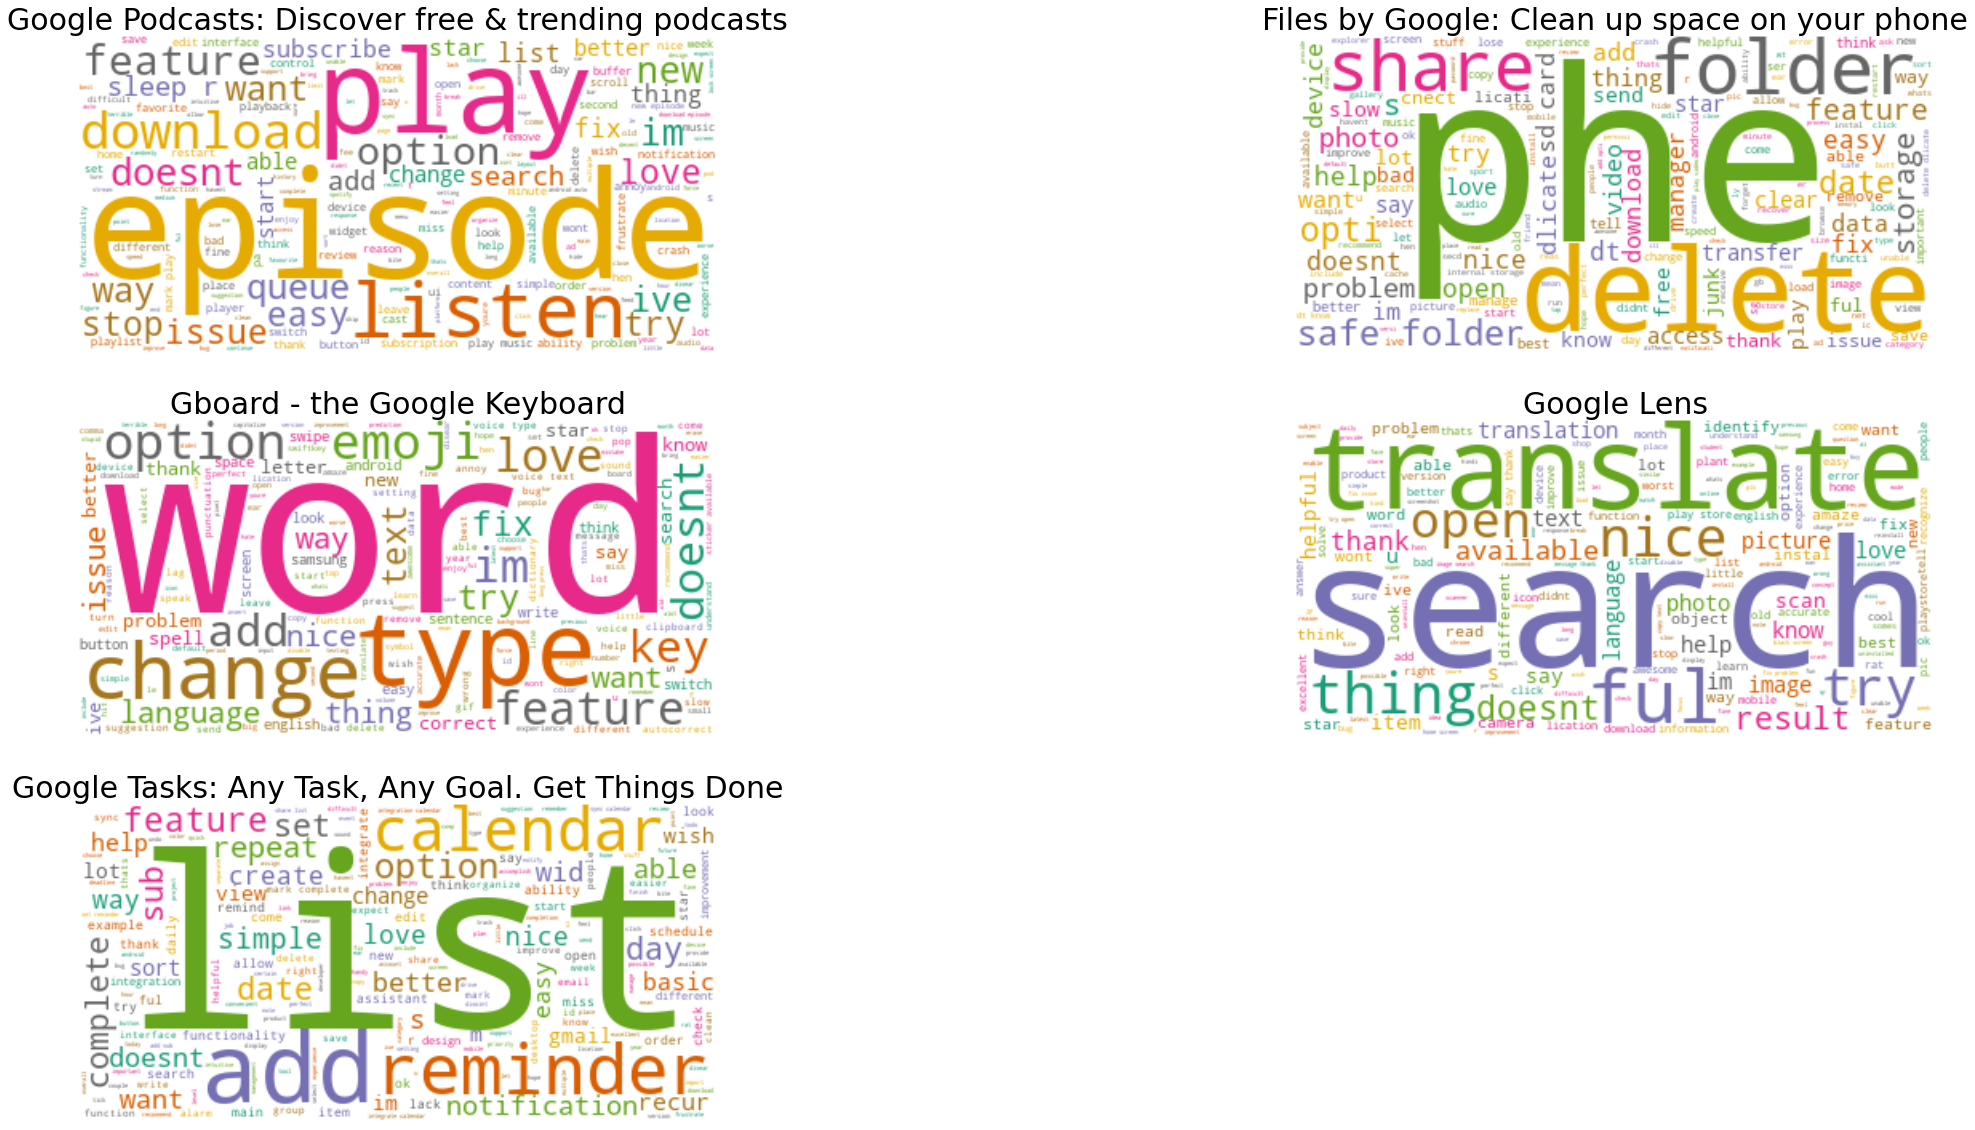

In [33]:
plt.rcParams['figure.figsize'] =[40,20]
full_appname=top5_app.index
Lem = WordNetLemmatizer()

for index, app in enumerate(top5_app.index):
    strings=' '.join(data_nouns_adj_V.content[df.title==app])
    for stop_word in app.split():
        word=re.sub(('[^-9A-Za-z]'),'',stop_word.lower())
        word=[Lem.lemmatize(word)]
        strings=strings.replace(word[0],'')
    strings=strings.replace('podcast','')
    for stop_word in add_stop_words:
        strings=strings.replace(stop_word,'')
    wc.generate(strings)
    plt.subplot(3,2,index+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(app,size=30)

### Word Cloud for Last 5 rate apps

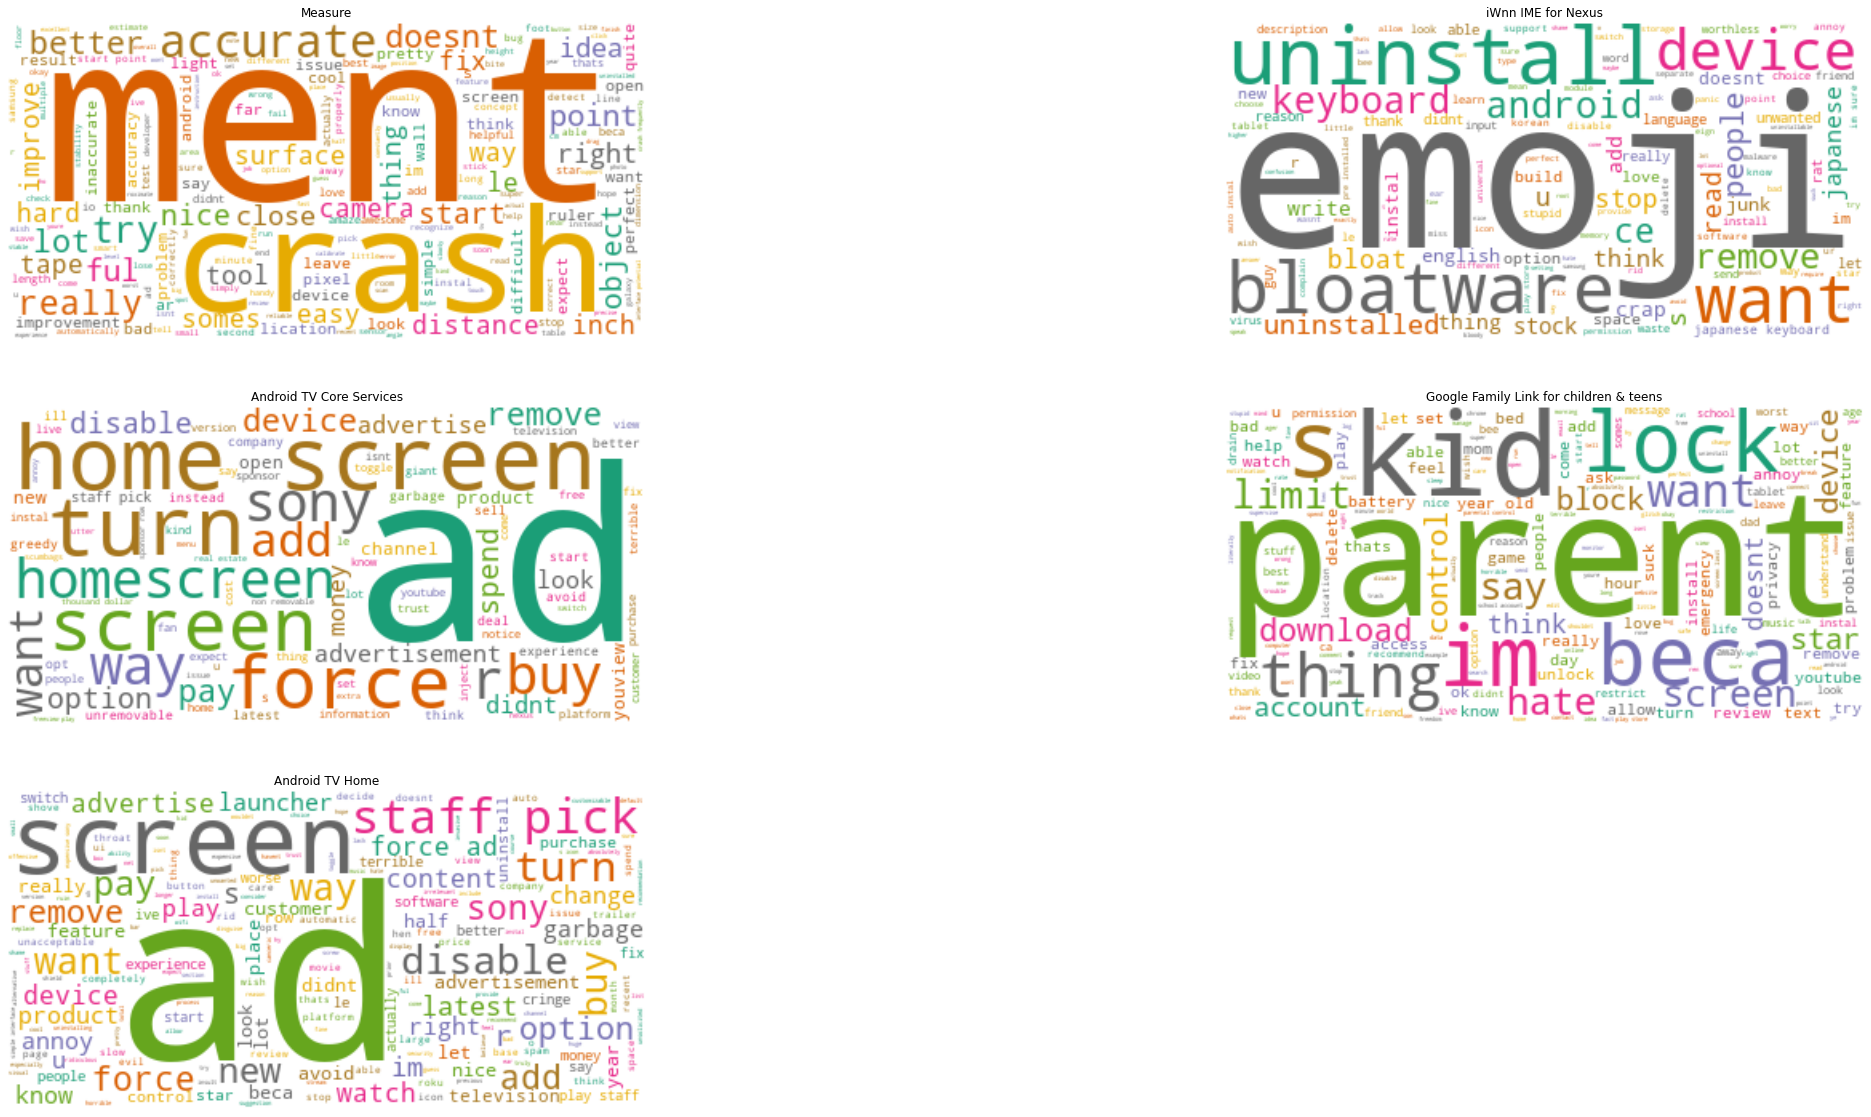

In [34]:
plt.rcParams['figure.figsize'] =[40,20]
full_appname=last5_app.index
Lem = WordNetLemmatizer()

for index, app in enumerate(last5_app.index):
    strings=' '.join(df.content[df.title==app])
    for stop_word in app.split():
        word=re.sub(('[^-9A-Za-z ]'),'',stop_word.lower())
        word=[Lem.lemmatize(word)]
        strings=strings.replace(word[0],'')
    for stop_word in add_stop_words:
        strings=strings.replace(stop_word,'')
    strings=strings.replace('podcast','')
    wc.generate(strings)
    plt.subplot(3,2,index+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(app)